# Capstone Project - The Battle of Neighborhoods (Week 2)
## _Finding Best Residential Areas for Long-Stay Foreign Tourists Coming to Osaka_

### Import libraries

In [47]:
import pandas as pd
import numpy as np
import requests
import time
!conda install -c conda-forge geocoder --yes
import geocoder
!conda install -c conda-forge bs4 --yes
from bs4 import BeautifulSoup
import ssl
import json
!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import folium

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


### Get the Contents of a Wikipedia Page

In [55]:
url = 'https://en.wikipedia.org/wiki/Osaka'
r = requests.get(url)
r.status_code

200

### Scrape the Contents

In [56]:
# instantiate a soup object with the response text
soup = BeautifulSoup(r.text, "html.parser")

# parse the table part of the response
postal_table = soup.find(class_="wikitable").findNext(class_="wikitable")

### Transform the Data into a pandas Dataframe

In [57]:
#print(postal_table)

In [58]:
# build the initial dataframe
table_rows = postal_table.find_all('tr')
row_values = []
for tr in table_rows:
    td = tr.find_all('td')
    row_text = [tr.text.strip() for tr in td if tr.text.strip()]
    if row_text:
        row_values.append(row_text)

osaka_df = pd.DataFrame(row_values, columns=['Number', 'Ward', 'Ward_inKanji', 'Population', 'LandArea_SqKm', "PopDensity_perSqKm"])
#osaka_df = osaka_df.set_index('Number')
osaka_df

,Number,Ward,Ward_inKanji,Population,LandArea_SqKm,PopDensity_perSqKm
0,1,Abeno-ku,阿倍野区,"107,000",5.99,"18,440"
1,2,Asahi-ku,旭区,"90,854",6.32,"14,376"
2,3,Chūō-ku,中央区,"100,998",8.87,"11,386"
3,4,Fukushima-ku,福島区,"78,348",4.67,"16,777"
4,5,Higashinari-ku,東成区,"83,684",4.54,"18,433"
5,6,Higashisumiyoshi-ku,東住吉区,"126,704",9.75,"12,995"
6,7,Higashiyodogawa-ku,東淀川区,"176,943",13.27,"13,334"
7,8,Hirano-ku,平野区,"193,282",15.28,"12,649"
8,9,Ikuno-ku,生野区,"129,641",8.37,"15,489"
9,10,Jōtō-ku,城東区,"167,925",8.38,"20,039"


### Clean the Dataframe

In [59]:
# drop the 'number' column
osaka_df.drop(['Number'], axis=1, inplace=True)

# replace the element in the list for 'Kita-ku'that contains an unnecessary descripion
osaka_df['Ward'][10] = 'Kita-ku'
#osaka_df['Ward'][10]

print(osaka_df.shape)
osaka_df.head(24)

(24, 5)


,Ward,Ward_inKanji,Population,LandArea_SqKm,PopDensity_perSqKm
0,Abeno-ku,阿倍野区,"107,000",5.99,"18,440"
1,Asahi-ku,旭区,"90,854",6.32,"14,376"
2,Chūō-ku,中央区,"100,998",8.87,"11,386"
3,Fukushima-ku,福島区,"78,348",4.67,"16,777"
4,Higashinari-ku,東成区,"83,684",4.54,"18,433"
5,Higashisumiyoshi-ku,東住吉区,"126,704",9.75,"12,995"
6,Higashiyodogawa-ku,東淀川区,"176,943",13.27,"13,334"
7,Hirano-ku,平野区,"193,282",15.28,"12,649"
8,Ikuno-ku,生野区,"129,641",8.37,"15,489"
9,Jōtō-ku,城東区,"167,925",8.38,"20,039"


### Explore the Basic Data

In [60]:
# transform the data types from string to numeric
osaka_df['Population'] = osaka_df['Population'].str.replace(',', '').astype(int)
osaka_df['LandArea_SqKm'] = osaka_df['LandArea_SqKm'].astype(float)
osaka_df['PopDensity_perSqKm'] = osaka_df['PopDensity_perSqKm'].str.replace(',', '').astype(int)

# generate summary statistics
osaka_df.describe(include='all')

,Ward,Ward_inKanji,Population,LandArea_SqKm,PopDensity_perSqKm
count,24,24,24.000000,24.000000,24.000000
unique,24,24,NaN,NaN,NaN
top,Sumiyoshi-ku,西区,NaN,NaN,NaN
freq,1,1,NaN,NaN,NaN
mean,NaN,NaN,114149.458333,9.385417,13768.500000
std,NaN,NaN,37605.994748,4.466964,4495.732759
min,NaN,NaN,62872.000000,4.390000,3381.000000
25%,NaN,NaN,82970.500000,6.057500,12333.250000
50%,NaN,NaN,107277.500000,8.375000,14397.500000
75%,NaN,NaN,131381.250000,10.915000,16853.250000


In [61]:
# order the wards by population
osaka_df[['Ward', 'Population']].sort_values(by='Population', ascending=False)

,Ward,Population
7,Hirano-ku,193282
23,Yodogawa-ku,182254
6,Higashiyodogawa-ku,176943
9,Jōtō-ku,167925
19,Sumiyoshi-ku,153425
10,Kita-ku,136602
8,Ikuno-ku,129641
5,Higashisumiyoshi-ku,126704
18,Suminoe-ku,120629
22,Tsurumi-ku,111501


In [62]:
# calculate the total population of Osaka
pop = osaka_df['Population'].sum()
pop

2739587

In [63]:
# order the wards by land area
osaka_df[['Ward', 'LandArea_SqKm']].sort_values(by='LandArea_SqKm', ascending=False)

,Ward,LandArea_SqKm
18,Suminoe-ku,20.61
11,Konohana-ku,19.25
7,Hirano-ku,15.28
17,Nishiyodogawa-ku,14.22
6,Higashiyodogawa-ku,13.27
23,Yodogawa-ku,12.64
10,Kita-ku,10.34
5,Higashisumiyoshi-ku,9.75
20,Taishō-ku,9.43
19,Sumiyoshi-ku,9.40


In [64]:
# calculate the total land area of Osaka
land = osaka_df['LandArea_SqKm'].sum()
land

225.25

In [65]:
# order the wards by population density
osaka_df[['Ward', 'PopDensity_perSqKm']].sort_values(by='PopDensity_perSqKm', ascending=False)

,Ward,PopDensity_perSqKm
9,Jōtō-ku,20039
15,Nishi-ku,19787
0,Abeno-ku,18440
4,Higashinari-ku,18433
13,Miyakojima-ku,17690
14,Naniwa-ku,17082
3,Fukushima-ku,16777
21,Tennōji-ku,16700
19,Sumiyoshi-ku,16322
8,Ikuno-ku,15489


### Get the Latitude & Longitude Coordinates of Each Ward and Create a Dataframe

In [66]:
osaka_coordi = pd.DataFrame(columns = ['Latitude','Longitude'])
geolocator = Nominatim(user_agent="Osaka_explorer")

for address in osaka_df['Ward']:
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    osaka_coordi = osaka_coordi.append({'Latitude': latitude, 'Longitude': longitude}, ignore_index=True)

osaka_df = osaka_df.join(osaka_coordi)
osaka_df

,Ward,Ward_inKanji,Population,LandArea_SqKm,PopDensity_perSqKm,Latitude,Longitude
0,Abeno-ku,阿倍野区,107000,5.99,18440,34.627501,135.514095
1,Asahi-ku,旭区,90854,6.32,14376,34.726483,135.546952
2,Chūō-ku,中央区,100998,8.87,11386,35.666255,139.775565
3,Fukushima-ku,福島区,78348,4.67,16777,34.692104,135.474812
4,Higashinari-ku,東成区,83684,4.54,18433,34.672912,135.550567
5,Higashisumiyoshi-ku,東住吉区,126704,9.75,12995,34.615662,135.531096
6,Higashiyodogawa-ku,東淀川区,176943,13.27,13334,34.740212,135.517432
7,Hirano-ku,平野区,193282,15.28,12649,34.603715,135.559027
8,Ikuno-ku,生野区,129641,8.37,15489,34.653003,135.547722
9,Jōtō-ku,城東区,167925,8.38,20039,34.693887,135.547769


## Create a Map and Further Explore the Data

In [67]:
# get the latitude & longitude values of Osaka
address = '1-3-20 Nakanoshima, Kita-ku, Osaka, Japan'
geolocator = Nominatim(user_agent="Osaka_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print('Coordinates of Osaka, Japan are {}, {}. '.format(latitude, longitude))

Coordinates of Osaka, Japan are 34.6941467, 135.5029254. 


### Create a Map of Osaka with its Wards Superimposed on Top

In [68]:
# create a map of Osaka using latitude & longitude values
map_osaka = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers
for lat, lng, ward in zip(osaka_df['Latitude'], osaka_df['Longitude'], osaka_df['Ward']):
    label = '{}'.format(ward)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.4,
        parse_html=False).add_to(map_osaka)
    
map_osaka

### Explore the Wards of Osaka City Utilizing the Foursquare API and Segment Them

In [69]:
# access Foursquare APIs
client_id = 'I0WSDFW5UEWAMMEATZRZL5B1VMKJV5TDZIAVJSGS1EVVBFST'
client_secret = 'KP1KVLWC4NMAVJSCPBODF0RIFXGPKZ2KDCIRMOO2TNMEO03X'
version = '20200513'

In [70]:
# first neighborhood in osaka_df
osaka_df.loc[0, 'Ward']

'Abeno-ku'

In [71]:
# get Abeno-ku's latitude & longitude values
abeno_latitude = osaka_df.loc[0, 'Latitude']
abeno_longitude = osaka_df.loc[0, 'Longitude']

print('Abeno-ku\'s latitude and longitude values are {}, {}.'.format(abeno_latitude, abeno_longitude))

Abeno-ku's latitude and longitude values are 34.627501, 135.514095.


In [72]:
# get the top 100 venues that are in Abeno-ku within a radius of 1000 metres
no_of_venues = 100
radius = 1000
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(client_id, client_secret, version, abeno_latitude, abeno_longitude, radius, no_of_venues)

response = requests.get(url).json()
response

{'meta': {'code': 200, 'requestId': '5ebba92977af030029b3ef26'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Abeno',
  'headerFullLocation': 'Abeno, Osaka',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 81,
  'suggestedBounds': {'ne': {'lat': 34.636501009000014,
    'lng': 135.5250120021143},
   'sw': {'lat': 34.61850099099999, 'lng': 135.5031779978857}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4ea8d1bf9adf64e06c205846',
       'name': 'Usagi to Boku (うさぎとぼく)',
       'location': {'address': '阿倍野区阪南町3-9-10',
        'lat': 34.629734,
        'lng': 135.515104,
        'labeledLatLngs': [{'label': 'display',
          'lat': 34.629734,
          'lng':

In [73]:
# function to extract the venue's category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [74]:
# clean the response json and structure it into pandas dataframe
venues = response['response']['groups'][0]['items']
# flatten json
nearby_venues = json_normalize(venues)
# filter only needed columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  after removing the cwd from sys.path.


,name,categories,lat,lng
0,Usagi to Boku (うさぎとぼく),Coffee Shop,34.629734,135.515104
1,スタンドアサヒ,Sake Bar,34.625118,135.520530
2,桃ヶ池公園,Park,34.631239,135.521659
3,ライフ セントラルスクエア 北畠店,Supermarket,34.626273,135.509131
4,阿倍王子神社,Shrine,34.631045,135.509169
...,...,...,...,...
76,デイリーカナート 晴明通店,Supermarket,34.632660,135.505467
77,それいゆ,Bakery,34.625175,135.503810
78,Matsumushi Station (松虫停留場),Light Rail Station,34.635686,135.509934
79,Cafe Pu-rin,Café,34.634649,135.520535


### Explore All Wards and its Venues

In [75]:
# explore all the wards of Osaka city using Foursquare APIs
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list = []
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(client_id, client_secret, version, lat, lng, radius, no_of_venues)
        results = requests.get(url).json()["response"]['groups'][0]['items']
        venues_list.append([(name, lat, lng, 
            v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])
        
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Ward', 'Ward Latitude', 'Ward Longitude',
                            'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    return(nearby_venues)

In [76]:
# run the above function on each ward and create a new dataframe called osaka_venues
osaka_venues = getNearbyVenues(names=osaka_df['Ward'],
                                 latitudes=osaka_df['Latitude'],
                                 longitudes=osaka_df['Longitude'])

Abeno-ku
Asahi-ku
Chūō-ku
Fukushima-ku
Higashinari-ku
Higashisumiyoshi-ku
Higashiyodogawa-ku
Hirano-ku
Ikuno-ku
Jōtō-ku
Kita-ku
Konohana-ku
Minato-ku
Miyakojima-ku
Naniwa-ku
Nishi-ku
Nishinari-ku
Nishiyodogawa-ku
Suminoe-ku
Sumiyoshi-ku
Taishō-ku
Tennōji-ku
Tsurumi-ku
Yodogawa-ku


In [77]:
# check how many venues were returned overall
print(osaka_venues.shape)
print('\n')
osaka_venues.head(10)

(1806, 7)




,Ward,Ward Latitude,Ward Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abeno-ku,34.627501,135.514095,Usagi to Boku (うさぎとぼく),34.629734,135.515104,Coffee Shop
1,Abeno-ku,34.627501,135.514095,スタンドアサヒ,34.625118,135.520530,Sake Bar
2,Abeno-ku,34.627501,135.514095,桃ヶ池公園,34.631239,135.521659,Park
3,Abeno-ku,34.627501,135.514095,ライフ セントラルスクエア 北畠店,34.626273,135.509131,Supermarket
4,Abeno-ku,34.627501,135.514095,阿倍王子神社,34.631045,135.509169,Shrine
5,Abeno-ku,34.627501,135.514095,いりふね温泉,34.621356,135.515746,Bath House
6,Abeno-ku,34.627501,135.514095,ハンバーグレストラン BOSTON 昭和町本店,34.632831,135.516725,American Restaurant
7,Abeno-ku,34.627501,135.514095,カフェ陶芸教室 森森舎,34.621420,135.506667,Café
8,Abeno-ku,34.627501,135.514095,ドミノ・ピザ 阿倍野昭和町店,34.631655,135.516555,Pizza Place
9,Abeno-ku,34.627501,135.514095,ライフ 昭和町駅前店,34.633665,135.517096,Grocery Store


In [78]:
# check the number of venues for each ward
osaka_venues.groupby('Ward')['Venue'].count()

Ward
Abeno-ku                81
Asahi-ku                59
Chūō-ku                100
Fukushima-ku           100
Higashinari-ku          80
Higashisumiyoshi-ku     55
Higashiyodogawa-ku      79
Hirano-ku               56
Ikuno-ku                57
Jōtō-ku                 63
Kita-ku                 85
Konohana-ku             45
Minato-ku              100
Miyakojima-ku           89
Naniwa-ku              100
Nishi-ku               100
Nishinari-ku           100
Nishiyodogawa-ku        63
Suminoe-ku              65
Sumiyoshi-ku            77
Taishō-ku               46
Tennōji-ku             100
Tsurumi-ku               6
Yodogawa-ku            100
Name: Venue, dtype: int64

In [79]:
# check the number of unique categories of venues
print('There are {} uniques categories.'.format(len(osaka_venues['Venue Category'].unique())))

There are 190 uniques categories.


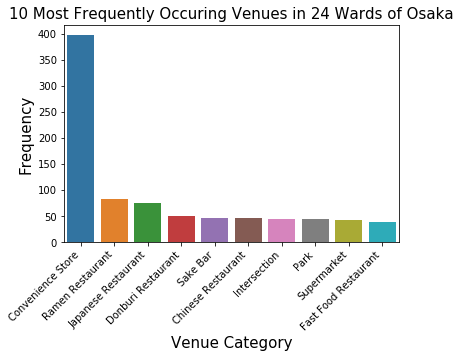

<Figure size 1296x504 with 0 Axes>

In [80]:
# create a dataframe of top 10 categories
osaka_venues_top10 = osaka_venues['Venue Category'].value_counts()[0:10].to_frame(name='frequency')
osaka_venues_top10 = osaka_venues_top10.reset_index()

osaka_venues_top10.rename(index=str, columns={"index": "Venue Category", "frequency": "Frequency"}, inplace=True)
osaka_venues_top10

# create a bar chart of 10 most frequently occuring venues in Osaka
s=sns.barplot(x="Venue Category", y="Frequency", data=osaka_venues_top10)
s.set_xticklabels(s.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.title('10 Most Frequently Occuring Venues in 24 Wards of Osaka', fontsize=15)
plt.xlabel("Venue Category", fontsize=15)
plt.ylabel ("Frequency", fontsize=15)
plt.savefig("Most_Freq_Venues1.png", dpi=300)
fig = plt.figure(figsize=(18,7))
plt.show()

### Do One-hot Encoding All Wards based on the Venue Category

In [81]:
# use one-hot encoding to create dummy variables for vanue categories
osaka_onehot = pd.get_dummies(osaka_venues[['Venue Category']], prefix="", prefix_sep="")

# add the ward column back to dataframe
osaka_onehot['Ward'] = osaka_venues['Ward'] 

# move the ward column to the first column
fixed_columns = [osaka_onehot.columns[-1]] + list(osaka_onehot.columns[:-1])
osaka_onehot = osaka_onehot[fixed_columns]

osaka_onehot.shape

(1806, 191)

### Group Rows by Ward and Take the Mean of the Frequency of Occurrence of Each Category

In [82]:
osaka_grouped = osaka_onehot.groupby('Ward').mean().reset_index()

print(osaka_grouped.shape)
osaka_grouped.head(24)

(24, 191)


,Ward,ATM,American Restaurant,Arcade,Art Gallery,Art Museum,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,...,Trail,Train Station,Tunnel,Udon Restaurant,Unagi Restaurant,Video Store,Wagashi Place,Wine Bar,Yakitori Restaurant,Yoshoku Restaurant
0,Abeno-ku,0.000000,0.012346,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.012346,0.000000,0.024691,0.00,0.000000,0.012346,0.000000,0.000000,0.00
1,Asahi-ku,0.000000,0.000000,0.000000,0.00,0.00,0.016949,0.000000,0.000000,0.00,...,0.000000,0.050847,0.000000,0.050847,0.00,0.000000,0.000000,0.000000,0.000000,0.00
2,Chūō-ku,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.010000,0.00,...,0.000000,0.000000,0.000000,0.000000,0.02,0.000000,0.000000,0.010000,0.000000,0.01
3,Fukushima-ku,0.010000,0.000000,0.000000,0.01,0.00,0.000000,0.000000,0.030000,0.00,...,0.000000,0.040000,0.000000,0.010000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
4,Higashinari-ku,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.012500,0.00,...,0.000000,0.012500,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
5,Higashisumiyoshi-ku,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.018182,0.018182,0.00,0.000000,0.000000,0.000000,0.000000,0.00
6,Higashiyodogawa-ku,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.012658,0.00,...,0.000000,0.050633,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00
7,Hirano-ku,0.000000,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.000000,0.00,...,0.000000,0.000000,0.000000,0.035714,0.00,0.000000,0.000000,0.000000,0.000000,0.00
8,Ikuno-ku,0.017544,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.017544,0.00,...,0.000000,0.000000,0.000000,0.035088,0.00,0.000000,0.000000,0.000000,0.000000,0.00
9,Jōtō-ku,0.015873,0.000000,0.000000,0.00,0.00,0.000000,0.000000,0.015873,0.00,...,0.000000,0.015873,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.00


### Each Ward with Top 5 Common Venues

In [83]:
num_top_venues = 5

for hood in osaka_grouped['Ward']:
    print("[--------"+hood+"--------]")
    temp = osaka_grouped[osaka_grouped['Ward'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq':2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

[--------Abeno-ku--------]
               venue  freq
0  Convenience Store  0.20
1               Park  0.04
2             Bakery  0.04
3           Sake Bar  0.04
4      Shopping Mall  0.04


[--------Asahi-ku--------]
               venue  freq
0  Convenience Store  0.29
1      Train Station  0.05
2   Ramen Restaurant  0.05
3      Metro Station  0.05
4    Udon Restaurant  0.05


[--------Chūō-ku--------]
                  venue  freq
0      Sushi Restaurant  0.19
1   Japanese Restaurant  0.12
2  Monjayaki Restaurant  0.07
3       Soba Restaurant  0.05
4    Italian Restaurant  0.05


[--------Fukushima-ku--------]
                  venue  freq
0     Convenience Store  0.27
1      Ramen Restaurant  0.06
2          Intersection  0.04
3  Fast Food Restaurant  0.04
4         Train Station  0.04


[--------Higashinari-ku--------]
                venue  freq
0   Convenience Store  0.30
1  Donburi Restaurant  0.06
2       Metro Station  0.04
3            Sake Bar  0.04
4       Grocery Store  0

### Create a Dataframe that Has Top 10 Venues for Each Ward

In [84]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [85]:
# create a dataframe to display top 10 venues for each ward
num_top_venues = 10
indicators = ['st', 'nd', 'rd', 'th']

columns = ['Ward']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
         columns.append('{}th Most Common Venue'.format(ind+1))
        
# create the new dataframe
ward_venues_sorted = pd.DataFrame(columns=columns)
ward_venues_sorted['Ward'] = osaka_grouped['Ward']

for ind in np.arange(osaka_grouped.shape[0]):
    ward_venues_sorted.iloc[ind, 1:] = return_most_common_venues(osaka_grouped.iloc[ind, :], num_top_venues)

ward_venues_sorted.shape

(24, 11)

### Run K-Means to Cluster the Wards

In [86]:
# set the number of clusters
kclusters = 4
osaka_grouped_clustering = osaka_grouped.drop('Ward', 1)

# run k-means clustering
kmeans = KMeans(n_init=300 , n_clusters=kclusters, random_state=5).fit(osaka_grouped_clustering)

#check cluster lables generated for each row in the dataframe
kmeans.labels_[0:20]

array([3, 0, 2, 0, 0, 0, 0, 3, 3, 3, 3, 3, 2, 0, 2, 0, 0, 0, 3, 0],
      dtype=int32)

### Create a New Dataframe that Includes the Clusters

In [87]:
# add cluster labels
ward_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
osaka_merged = osaka_df

# merge osaka_grouped with osaka_dataframe to add latitude & longitue for each ward
osaka_merged = osaka_merged.join(ward_venues_sorted.set_index('Ward'), on='Ward')
osaka_merged.head()

,Ward,Ward_inKanji,Population,LandArea_SqKm,PopDensity_perSqKm,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abeno-ku,阿倍野区,107000,5.99,18440,34.627501,135.514095,3,Convenience Store,Grocery Store,Bakery,Supermarket,Park,Shopping Mall,Café,Donburi Restaurant,Sake Bar,Intersection
1,Asahi-ku,旭区,90854,6.32,14376,34.726483,135.546952,0,Convenience Store,Ramen Restaurant,Udon Restaurant,Train Station,Metro Station,Supermarket,Donburi Restaurant,Noodle House,Intersection,Shopping Mall
2,Chūō-ku,中央区,100998,8.87,11386,35.666255,139.775565,2,Sushi Restaurant,Japanese Restaurant,Monjayaki Restaurant,Soba Restaurant,Italian Restaurant,Bakery,Coffee Shop,Ramen Restaurant,Seafood Restaurant,Kaiseki Restaurant
3,Fukushima-ku,福島区,78348,4.67,16777,34.692104,135.474812,0,Convenience Store,Ramen Restaurant,Fast Food Restaurant,Intersection,Train Station,Donburi Restaurant,Shopping Mall,Supermarket,BBQ Joint,Chinese Restaurant
4,Higashinari-ku,東成区,83684,4.54,18433,34.672912,135.550567,0,Convenience Store,Donburi Restaurant,Sake Bar,Grocery Store,Metro Station,Intersection,Ramen Restaurant,Pharmacy,Park,Supermarket


### Visualize the Clusters

In [88]:
# create a map
cluster_map = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color schemes
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(osaka_merged['Latitude'], osaka_merged['Longitude'], osaka_merged['Ward'], osaka_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=9,
    popup=label,
    colors=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.4).add_to(cluster_map)

cluster_map

### Examine Each Cluster and Determine the Discriminating Venue Categories that Distinguish Each Cluster

In [89]:
# Cluster 1
osaka_merged.loc[osaka_merged['Cluster Labels'] == 0, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,Ward,PopDensity_perSqKm,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Asahi-ku,14376,34.726483,135.546952,0,Convenience Store,Ramen Restaurant,Udon Restaurant,Train Station,Metro Station,Supermarket,Donburi Restaurant,Noodle House,Intersection,Shopping Mall
3,Fukushima-ku,16777,34.692104,135.474812,0,Convenience Store,Ramen Restaurant,Fast Food Restaurant,Intersection,Train Station,Donburi Restaurant,Shopping Mall,Supermarket,BBQ Joint,Chinese Restaurant
4,Higashinari-ku,18433,34.672912,135.550567,0,Convenience Store,Donburi Restaurant,Sake Bar,Grocery Store,Metro Station,Intersection,Ramen Restaurant,Pharmacy,Park,Supermarket
5,Higashisumiyoshi-ku,12995,34.615662,135.531096,0,Convenience Store,Intersection,Ramen Restaurant,Restaurant,Sushi Restaurant,Bus Stop,Shopping Mall,Pharmacy,Donburi Restaurant,Japanese Restaurant
6,Higashiyodogawa-ku,13334,34.740212,135.517432,0,Convenience Store,Ramen Restaurant,Train Station,Donburi Restaurant,Chinese Restaurant,Supermarket,Drugstore,Japanese Restaurant,Fast Food Restaurant,Bus Stop
13,Miyakojima-ku,17690,34.712703,135.529697,0,Convenience Store,Park,Ramen Restaurant,Donburi Restaurant,Restaurant,Japanese Restaurant,Fast Food Restaurant,Bakery,Chinese Restaurant,Video Store
15,Nishi-ku,19787,34.674598,135.476774,0,Convenience Store,Shopping Mall,Train Station,Japanese Restaurant,Ramen Restaurant,Baseball Stadium,Clothing Store,Supermarket,Fast Food Restaurant,Grocery Store
16,Nishinari-ku,14743,34.639074,135.490813,0,Convenience Store,Shopping Mall,Grocery Store,Train Station,Chinese Restaurant,Fast Food Restaurant,Donburi Restaurant,Supermarket,Japanese Restaurant,Sake Bar
17,Nishiyodogawa-ku,6748,34.705938,135.442936,0,Convenience Store,Grocery Store,Park,Intersection,Clothing Store,Train Station,Japanese Restaurant,Shopping Mall,Fast Food Restaurant,Discount Store
19,Sumiyoshi-ku,16322,34.599765,135.506426,0,Convenience Store,Grocery Store,Chinese Restaurant,Platform,Ramen Restaurant,BBQ Joint,Diner,Noodle House,Fast Food Restaurant,Train Station


In [90]:
# Cluster 2
osaka_merged.loc[osaka_merged['Cluster Labels'] == 1, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,Ward,PopDensity_perSqKm,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Tsurumi-ku,13648,35.480132,139.693663,1,Bus Stop,Scenic Lookout,Park,Train Station,Trail,Pool,Yoshoku Restaurant,Food Court,Gift Shop,German Restaurant


In [91]:
# Cluster 3
osaka_merged.loc[osaka_merged['Cluster Labels'] == 2, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,Ward,PopDensity_perSqKm,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Chūō-ku,11386,35.666255,139.775565,2,Sushi Restaurant,Japanese Restaurant,Monjayaki Restaurant,Soba Restaurant,Italian Restaurant,Bakery,Coffee Shop,Ramen Restaurant,Seafood Restaurant,Kaiseki Restaurant
12,Minato-ku,10275,35.643227,139.740055,2,Japanese Restaurant,Chinese Restaurant,Italian Restaurant,Soba Restaurant,Coffee Shop,Sake Bar,Indian Restaurant,BBQ Joint,Bistro,Ramen Restaurant
14,Naniwa-ku,17082,34.662830,135.490485,2,Café,Hotel,Sake Bar,Japanese Restaurant,Coffee Shop,Grocery Store,Udon Restaurant,Ramen Restaurant,BBQ Joint,Italian Restaurant


In [92]:
# Cluster - 4
osaka_merged.loc[osaka_merged['Cluster Labels'] == 3, osaka_merged.columns[[0] + list(range(4, osaka_merged.shape[1]))]]

,Ward,PopDensity_perSqKm,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abeno-ku,18440,34.627501,135.514095,3,Convenience Store,Grocery Store,Bakery,Supermarket,Park,Shopping Mall,Café,Donburi Restaurant,Sake Bar,Intersection
7,Hirano-ku,12649,34.603715,135.559027,3,Convenience Store,Chinese Restaurant,Ramen Restaurant,Japanese Restaurant,Italian Restaurant,Donburi Restaurant,Supermarket,Metro Station,Udon Restaurant,Pet Store
8,Ikuno-ku,15489,34.653003,135.547722,3,Convenience Store,Ramen Restaurant,Chinese Restaurant,Drugstore,Intersection,Italian Restaurant,Korean Restaurant,Udon Restaurant,Clothing Store,Park
9,Jōtō-ku,20039,34.693887,135.547769,3,Convenience Store,Supermarket,Ramen Restaurant,Restaurant,Fast Food Restaurant,Grocery Store,Chinese Restaurant,Park,Intersection,Metro Station
10,Kita-ku,13211,35.755838,139.736687,3,Convenience Store,Park,Ramen Restaurant,Intersection,Sake Bar,Japanese Restaurant,Grocery Store,Museum,History Museum,Drugstore
11,Konohana-ku,3381,34.676245,135.435550,3,Convenience Store,Intersection,Train Station,Theme Park Ride / Attraction,Park,Hotel,Bus Stop,American Restaurant,Theme Park,Bus Station
18,Suminoe-ku,5853,34.614132,135.466545,3,Convenience Store,Fast Food Restaurant,Ramen Restaurant,Japanese Restaurant,Drugstore,Donburi Restaurant,Discount Store,BBQ Joint,Light Rail Station,Café
20,Taishō-ku,6667,34.650640,135.469570,3,Convenience Store,Pier,Chinese Restaurant,Shopping Mall,Fast Food Restaurant,Grocery Store,Donburi Restaurant,Ramen Restaurant,Discount Store,Deli / Bodega
21,Tennōji-ku,16700,34.655043,135.518370,3,Convenience Store,Donburi Restaurant,Japanese Restaurant,Historic Site,Coffee Shop,Ramen Restaurant,Sake Bar,BBQ Joint,Tonkatsu Restaurant,Bakery
